In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from numpy.random import seed
seed(123)


2024-05-10 13:10:36.433645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.1


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

/var/folders/k_/2tytwy6d2ll1_kvk_k0j7vd00000gn/T/ipykernel_8213/4204620386.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult/adult.data', sep=", ",header = None)
/var/folders/k_/2tytwy6d2ll1_kvk_k0j7vd00000gn/T/ipykernel_8213/4204620386.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

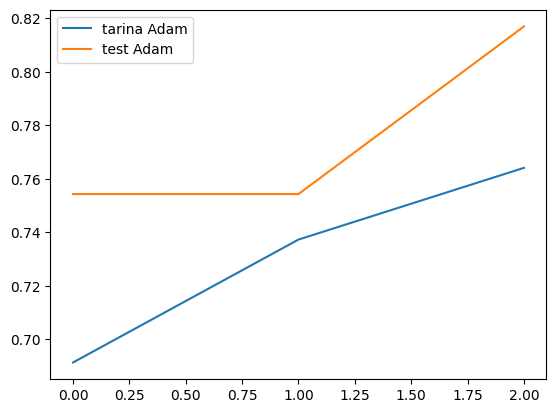

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
```python
model.add(Dropout(0.8))
```
w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)

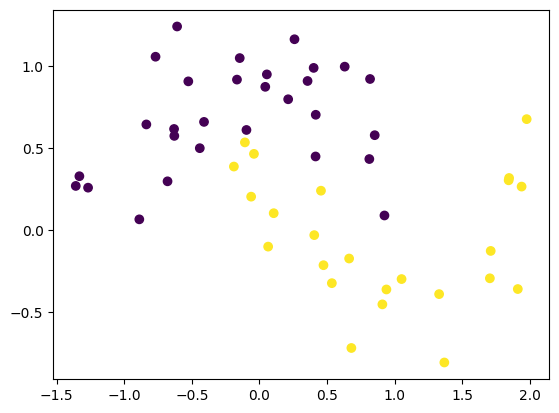

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [9]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              3000      
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dense_10 (Dense)            (None, 200)               100200    
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 603901 (2.30 MB)
Trainable params: 603901 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 1s 180ms/step - loss: 0.7420 - accuracy: 0.5094 - val_loss: 0.8464 - val_accuracy: 0.4468
Epoch 2/1

53/53 [==============================] - 0s 623us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2584 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2592 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2591 - val_accuracy: 0.9149
Epoch 502/1000
53/53 [==============================] - 0s 566us/step - loss: 9.9868e-04 - accuracy: 1.0000 - val_loss: 0.2574 - val_accuracy: 0.9149
Epoch 503/1000
53/53 [==============================] - 0s 566us/step - loss: 9.8344e-04 - accuracy: 1.0000 - val_loss: 0.2558 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 566us/step - loss: 9.9346e-04 - accuracy: 1.0000 - val_loss: 0.2553 - val_accuracy: 0.9149
Epoch 505/1000
53/53 [==============================] - 0s 642us/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2551 - va

Epoch 554/1000
53/53 [==============================] - 0s 642us/step - loss: 7.7759e-04 - accuracy: 1.0000 - val_loss: 0.2729 - val_accuracy: 0.9149
Epoch 555/1000
53/53 [==============================] - 0s 529us/step - loss: 7.8914e-04 - accuracy: 1.0000 - val_loss: 0.2731 - val_accuracy: 0.9149
Epoch 556/1000
53/53 [==============================] - 0s 604us/step - loss: 7.8336e-04 - accuracy: 1.0000 - val_loss: 0.2732 - val_accuracy: 0.9149
Epoch 557/1000
53/53 [==============================] - 0s 623us/step - loss: 7.7146e-04 - accuracy: 1.0000 - val_loss: 0.2737 - val_accuracy: 0.9149
Epoch 558/1000
53/53 [==============================] - 0s 585us/step - loss: 7.6927e-04 - accuracy: 1.0000 - val_loss: 0.2737 - val_accuracy: 0.9149
Epoch 559/1000
53/53 [==============================] - 0s 604us/step - loss: 7.5889e-04 - accuracy: 1.0000 - val_loss: 0.2729 - val_accuracy: 0.9149
Epoch 560/1000
53/53 [==============================] - 0s 661us/step - loss: 7.4502e-04 - accuracy:

Epoch 663/1000
53/53 [==============================] - 0s 566us/step - loss: 4.7822e-04 - accuracy: 1.0000 - val_loss: 0.2976 - val_accuracy: 0.9149
Epoch 664/1000
53/53 [==============================] - 0s 529us/step - loss: 4.8387e-04 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 0.9149
Epoch 665/1000
53/53 [==============================] - 0s 566us/step - loss: 4.7473e-04 - accuracy: 1.0000 - val_loss: 0.2988 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 623us/step - loss: 4.7411e-04 - accuracy: 1.0000 - val_loss: 0.2994 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 642us/step - loss: 4.7917e-04 - accuracy: 1.0000 - val_loss: 0.2994 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 642us/step - loss: 4.8599e-04 - accuracy: 1.0000 - val_loss: 0.3002 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 623us/step - loss: 4.7542e-04 - accuracy:

Epoch 772/1000
53/53 [==============================] - 0s 604us/step - loss: 3.2967e-04 - accuracy: 1.0000 - val_loss: 0.3196 - val_accuracy: 0.9149
Epoch 773/1000
53/53 [==============================] - 0s 604us/step - loss: 3.2682e-04 - accuracy: 1.0000 - val_loss: 0.3205 - val_accuracy: 0.9149
Epoch 774/1000
53/53 [==============================] - 0s 548us/step - loss: 3.2420e-04 - accuracy: 1.0000 - val_loss: 0.3212 - val_accuracy: 0.9149
Epoch 775/1000
53/53 [==============================] - 0s 585us/step - loss: 3.2268e-04 - accuracy: 1.0000 - val_loss: 0.3219 - val_accuracy: 0.9149
Epoch 776/1000
53/53 [==============================] - 0s 623us/step - loss: 3.2169e-04 - accuracy: 1.0000 - val_loss: 0.3226 - val_accuracy: 0.9149
Epoch 777/1000
53/53 [==============================] - 0s 566us/step - loss: 3.2123e-04 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9149
Epoch 778/1000
53/53 [==============================] - 0s 566us/step - loss: 3.2703e-04 - accuracy:

Epoch 881/1000
53/53 [==============================] - 0s 680us/step - loss: 2.3536e-04 - accuracy: 1.0000 - val_loss: 0.3440 - val_accuracy: 0.9149
Epoch 882/1000
53/53 [==============================] - 0s 661us/step - loss: 2.3370e-04 - accuracy: 1.0000 - val_loss: 0.3456 - val_accuracy: 0.9149
Epoch 883/1000
53/53 [==============================] - 0s 585us/step - loss: 2.3310e-04 - accuracy: 1.0000 - val_loss: 0.3467 - val_accuracy: 0.9149
Epoch 884/1000
53/53 [==============================] - 0s 566us/step - loss: 2.3983e-04 - accuracy: 1.0000 - val_loss: 0.3476 - val_accuracy: 0.9149
Epoch 885/1000
53/53 [==============================] - 0s 585us/step - loss: 2.3450e-04 - accuracy: 1.0000 - val_loss: 0.3475 - val_accuracy: 0.9149
Epoch 886/1000
53/53 [==============================] - 0s 585us/step - loss: 2.3248e-04 - accuracy: 1.0000 - val_loss: 0.3472 - val_accuracy: 0.9149
Epoch 887/1000
53/53 [==============================] - 0s 529us/step - loss: 2.3532e-04 - accuracy:

Epoch 990/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.7475e-04 - accuracy: 1.0000 - val_loss: 0.3641 - val_accuracy: 0.9149
Epoch 991/1000
53/53 [==============================] - 0s 736us/step - loss: 1.8039e-04 - accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.9149
Epoch 992/1000
53/53 [==============================] - 0s 623us/step - loss: 1.7887e-04 - accuracy: 1.0000 - val_loss: 0.3640 - val_accuracy: 0.9149
Epoch 993/1000
53/53 [==============================] - 0s 681us/step - loss: 1.7605e-04 - accuracy: 1.0000 - val_loss: 0.3648 - val_accuracy: 0.9149
Epoch 994/1000
53/53 [==============================] - 0s 699us/step - loss: 1.7353e-04 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 0.9149
Epoch 995/1000
53/53 [==============================] - 0s 616us/step - loss: 1.7188e-04 - accuracy: 1.0000 - val_loss: 0.3664 - val_accuracy: 0.9149
Epoch 996/1000
53/53 [==============================] - 0s 850us/step - loss: 1.7743e-04 - accuracy: 1

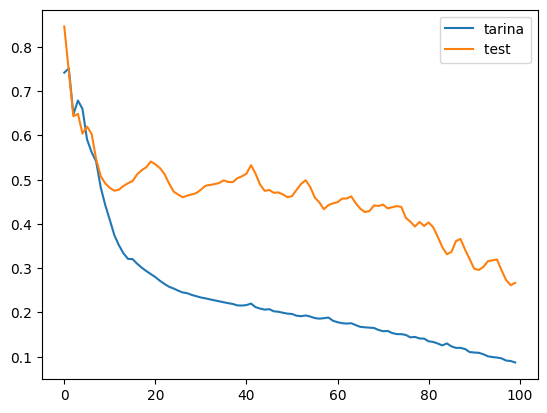

In [10]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

9600/9600 [==============================] - 13s 1ms/step


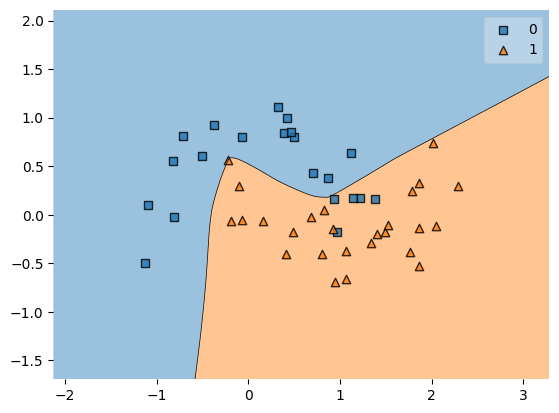

In [11]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)
* porównaj do powyższego eksperymentu

# Regularyzacja

# Zad.
Do modelu dodaj 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [12]:
from keras.callbacks import History
from keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              3000      
                                                                 
 dense_13 (Dense)            (None, 500)               500500    
                                                                 
 dense_14 (Dense)            (None, 200)               100200    
                                                                 
 dense_15 (Dense)            (None, 1)                 201       
                                                                 
Total params: 603901 (2.30 MB)
Trainable params: 603901 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 1s 216ms/step - loss: 0.7186 - accuracy: 0.5472 - val_loss: 0.7318 - val_accuracy: 0.5532
Epoch 2/

53/53 [==============================] - 0s 548us/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 0.3118 - val_accuracy: 0.8936
Epoch 386/1000
53/53 [==============================] - 0s 314us/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 0.3097 - val_accuracy: 0.8936
Epoch 387/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8936
Epoch 388/1000
53/53 [==============================] - 0s 825us/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8936
Epoch 389/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0538 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.8936
Epoch 390/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.3099 - val_accuracy: 0.8936
Epoch 391/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.3105 - val_accuracy: 

53/53 [==============================] - 0s 492us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.8936
Epoch 498/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.9149
Epoch 499/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0469 - accuracy: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2936 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0467 - accuracy: 1.0000 - val_loss: 0.2918 - val_accuracy: 0.8936
Epoch 502/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2906 - val_accuracy: 0.8936
Epoch 503/1000
53/53 [==============================] - 0s 589us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2907 - val_accuracy: 

Epoch 609/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.2710 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0417 - accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.2686 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.2670 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.2667 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2671 - val_accuracy: 0.9149
Epoch 615/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2669 -

Epoch 665/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.2584 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2575 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2569 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2564 - val_accuracy: 0.9149
Epoch 670/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2573 - val_accuracy: 0.9149
Epoch 671/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2582 -

Epoch 721/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.2456 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2439 - val_accuracy: 0.9149
Epoch 724/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9149
Epoch 725/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2448 - val_accuracy: 0.9149
Epoch 726/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9149
Epoch 727/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2451 -

53/53 [==============================] - 0s 295us/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.2359 - val_accuracy: 0.9149
Epoch 833/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9149
Epoch 834/1000
53/53 [==============================] - 0s 776us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.9149
Epoch 835/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2369 - val_accuracy: 0.9149
Epoch 836/1000
53/53 [==============================] - 0s 246us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2373 - val_accuracy: 0.9149
Epoch 837/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9149
Epoch 838/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2354 - val_accuracy: 

53/53 [==============================] - 0s 491us/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9362
Epoch 945/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2239 - val_accuracy: 0.9149
Epoch 946/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.2246 - val_accuracy: 0.9149
Epoch 947/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2253 - val_accuracy: 0.9149
Epoch 948/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2256 - val_accuracy: 0.9149
Epoch 949/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 950/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2250 - val_accuracy: 

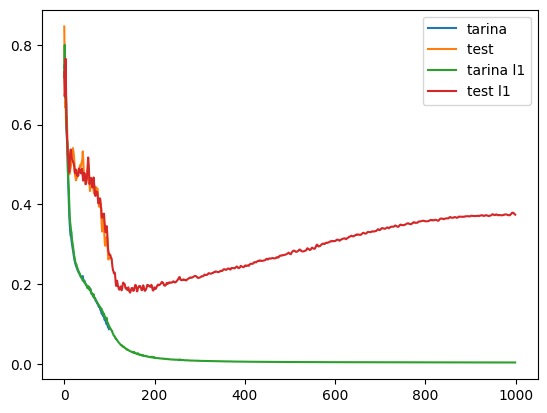

In [13]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

9600/9600 [==============================] - 15s 2ms/step


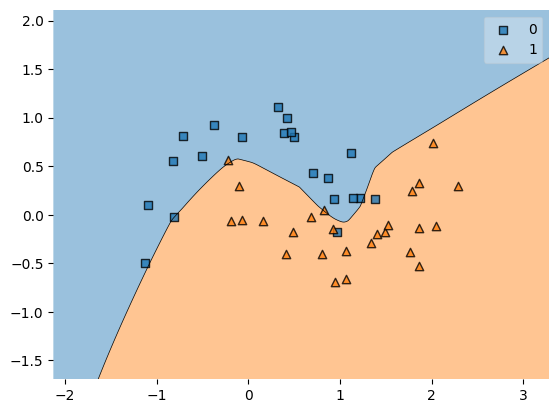

In [14]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()